# Exercizes on clustering

Here you can find a program to read a data file in csv format. 

The data file has the following heading:
    number of samples, number of features
    list of the names of the features (separated by comma)
    
The remaining lines contain an example per row.
For each row there is a list of real numbers (commas separated) which are the feature values.   

In [5]:
import csv
import sys
from os.path import join

import numpy as np
 
# this function reads the data file, loads the configuration attributes specifiefd in the heading
# (numer of examples and features), the list of feature names
# and loads the data in a matrix named data    
def load_data(file_path, file_name):
   with open(join(file_path, file_name)) as csv_file:
       data_file = csv.reader(csv_file,delimiter=',')
       temp1 = next(data_file)
       n_samples = int(temp1[0])
       print("n_samples=")
       print(n_samples)
       n_features = int(temp1[1])
       temp2 = next(data_file)
       feature_names = np.array(temp2[:n_features])

       data_list = [iter for iter in data_file]
               
       data = np.asarray(data_list, dtype=np.float64)                  
       
   return(data,feature_names,n_samples,n_features)

# The main program reads the input file containing the dataset
# file_path is the file path where the file with the data to be read are located
# we assume the file contains an example per line
# each example is a list of real values separated by a comma (csv format)
# The first line of the file contains the heading with:
# N_samples,n_features,
# The second line contains the feature names separated by a comma     

#file_path="content/"
file_path="./sample_data/"
# all the three datasets contain data points on (x,y) 
file_name1="3-clusters.csv"
file_name2="dataset-DBSCAN.csv"     
file_name3="CURE-complete.csv"    
data1,feature_names1,n_samples1,n_features1 = load_data(file_path, file_name1)
data2,feature_names2,n_samples2,n_features2 = load_data(file_path, file_name2)
data3,feature_names3,n_samples3,n_features3 = load_data(file_path, file_name3)
print("dataset n. 1: n samples, n features")
print(n_samples1, n_features1)
print("dataset n. 2: n samples, n features")
print(n_samples2, n_features2)
print("dataset n. 3: n samples, n features")
print(n_samples3, n_features3)

n_samples=
150
n_samples=
6118
n_samples=
86558
dataset n. 1: n samples, n features
150 2
dataset n. 2: n samples, n features
6118 2
dataset n. 3: n samples, n features
86558 2


The following program plots the dataset n.1

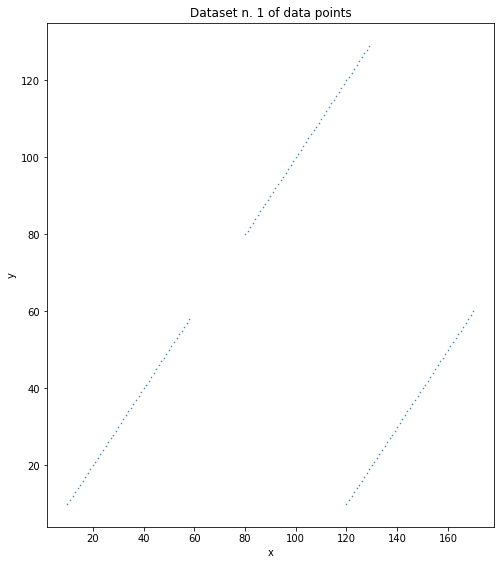

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)
fig.subplots_adjust(top=1)
ax.set_title('Dataset n. 1 of data points')

ax.set_xlabel(feature_names1[0])
ax.set_ylabel(feature_names1[1])

#plot the dataset
plt.plot(data1[:,0], data1[:,1], '.',markersize=1)

plt.show()

The following is the program for plotting the dataset n.2

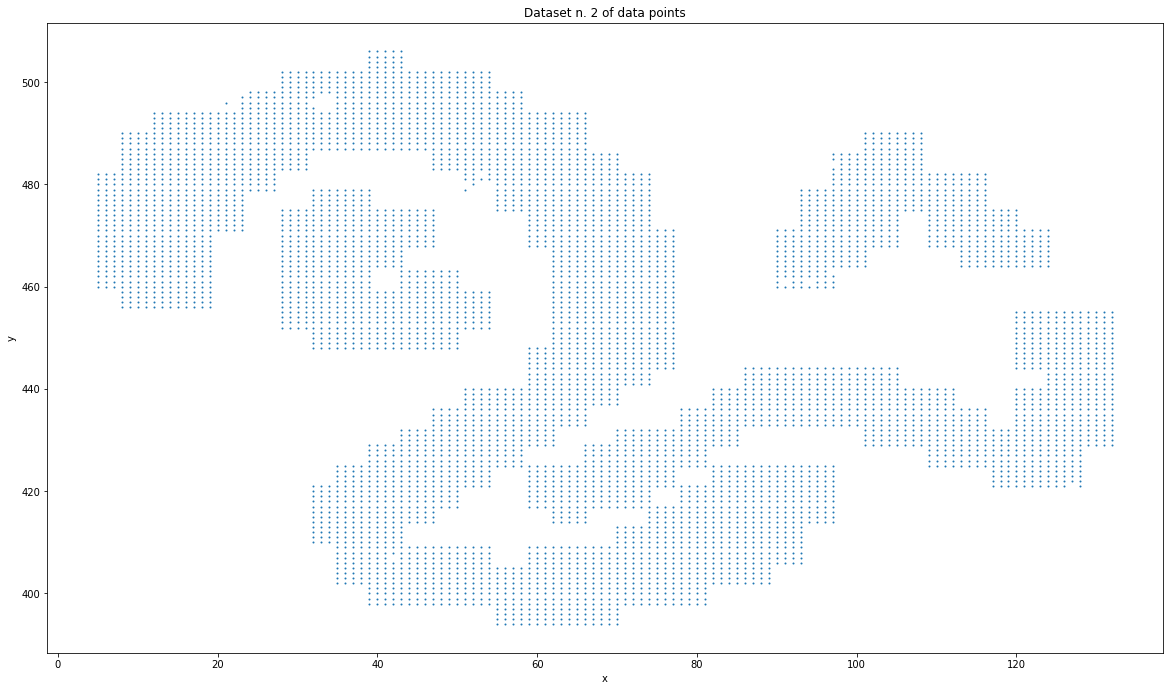

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(111)
fig.subplots_adjust(top=1)
ax.set_title('Dataset n. 2 of data points')

ax.set_xlabel(feature_names2[0])
ax.set_ylabel(feature_names2[1])

#plot the dataset
plt.plot(data2[:,0], data2[:,1], '.', markersize=2)

plt.show()

The following is the program for plotting the dataset n.3

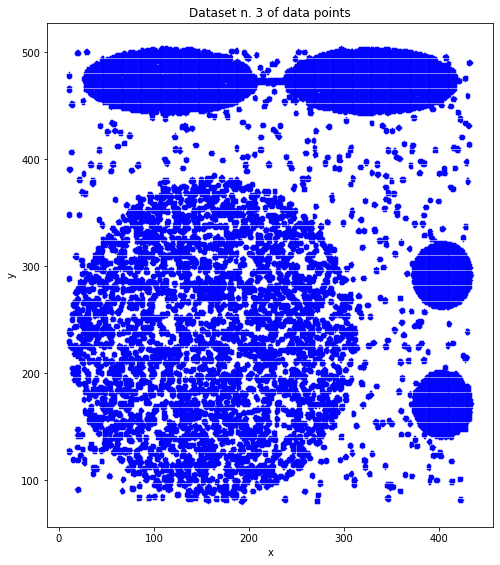

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)
fig.subplots_adjust(top=1)
ax.set_title('Dataset n. 3 of data points')

ax.set_xlabel(feature_names3[0])
ax.set_ylabel(feature_names3[1])

#plot the dataset
plt.plot(data3[:,0], data3[:,1], '.', markersize=1.2, markeredgecolor = 'blue')

plt.show()

## In the following program we cluster the dataset n.1 with K-means. 
From the plot of dataset n.1 we see 3 separated clusters. Thus k=3. 

In [13]:
import csv
import sys
from os.path import join

import numpy as np
 
def load_data(file_path, file_name):
   with open(join(file_path, file_name)) as csv_file:
       data_file = csv.reader(csv_file,delimiter=',')
       temp1 = next(data_file)
       n_samples = int(temp1[0])
       n_features = int(temp1[1])
       temp2 = next(data_file)
       feature_names = np.array(temp2[:n_features])

       data_list = [iter for iter in data_file]
               
       data = np.asarray(data_list, dtype=np.float64)                  
       
   return(data,feature_names,n_samples,n_features)

# The main program reads the input file containing the dataset
# file_path is the file path where the file with the data to be read are located
# we assume the file contains an example per line
# each example is a list of real values separated by a comma (csv format)
# The first line of the file contains the heading with:
# N_samples,n_features,
# The second line contains the feature names separated by a comma     

#file_path="~/meo/Documents/Didattica/Laboratorio-15-16-Jupyter/"
file_path="./sample_data/"
# all the three datasets contain data points on (x,y) 
file_name1="3-clusters.csv"

data1,feature_names1,n_samples1,n_features1 = load_data(file_path, file_name1)

from sklearn.cluster import KMeans

np.random.seed(5)

k=3
kmeans1 = KMeans(n_clusters=k, random_state=0).fit(data1)

i=0
for i in range(n_samples1):
    print("Example n."+str(i)+"=("+str(data1[i,0])+","+str(data1[i,1])+")")
    print("in cluster n."+str(kmeans1.labels_[i]))

Example n.0=(10.0,10.0)
in cluster n.0
Example n.1=(11.0,11.0)
in cluster n.0
Example n.2=(12.0,12.0)
in cluster n.0
Example n.3=(13.0,13.0)
in cluster n.0
Example n.4=(14.0,14.0)
in cluster n.0
Example n.5=(15.0,15.0)
in cluster n.0
Example n.6=(16.0,16.0)
in cluster n.0
Example n.7=(17.0,17.0)
in cluster n.0
Example n.8=(18.0,18.0)
in cluster n.0
Example n.9=(19.0,19.0)
in cluster n.0
Example n.10=(20.0,20.0)
in cluster n.0
Example n.11=(21.0,21.0)
in cluster n.0
Example n.12=(22.0,22.0)
in cluster n.0
Example n.13=(23.0,23.0)
in cluster n.0
Example n.14=(24.0,24.0)
in cluster n.0
Example n.15=(25.0,25.0)
in cluster n.0
Example n.16=(26.0,26.0)
in cluster n.0
Example n.17=(27.0,27.0)
in cluster n.0
Example n.18=(28.0,28.0)
in cluster n.0
Example n.19=(29.0,29.0)
in cluster n.0
Example n.20=(30.0,30.0)
in cluster n.0
Example n.21=(31.0,31.0)
in cluster n.0
Example n.22=(32.0,32.0)
in cluster n.0
Example n.23=(33.0,33.0)
in cluster n.0
Example n.24=(34.0,34.0)
in cluster n.0
Example n.

In the following program we plot the clusters

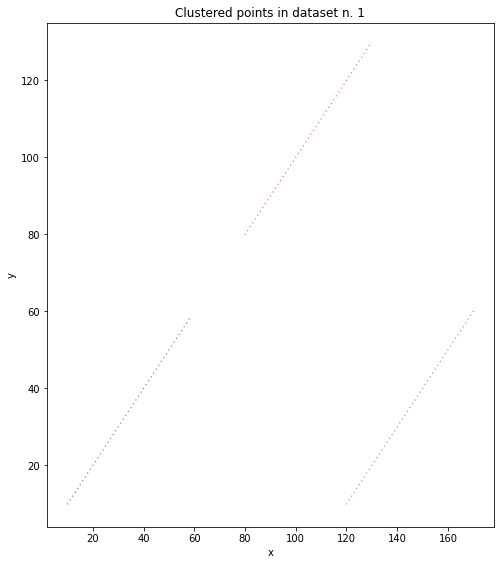

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)
fig.subplots_adjust(top=1)
ax.set_title('Clustered points in dataset n. 1')

ax.set_xlabel('x')
ax.set_ylabel('y')

# set the list of colors to be selected when plotting the different clusters
color=['b','g','r','c','m','y','k','w']
    
#plot the dataset
for clu in range(k):
    # collect the sequence of cooordinates of the points in each given cluster (determined by clu)
    data_list_x = [data1[i,0] for i in range(n_samples1) if kmeans1.labels_[i]==clu]
    data_list_y = [data1[i,1] for i in range(n_samples1) if kmeans1.labels_[i]==clu]
    plt.scatter(data_list_x, data_list_y, s=2, edgecolors='none', c=color[clu], alpha=0.5)

plt.show()

In the following cell I propose you to perform clustering with K-means on dataset2.

In the following you have to plot clustering results on dataset2.

**Answer:** 
how do you explain what it happens?

In the following cell I propose you to perform clustering with K-means on the dataset3.

In the following cell, I propose you to plot clustering results on dataset3.

**Answer:** 
how do you explain what it happens?

In the following cells I propose you to write a program that computes with a statistical measure of your choice a quantitative evaluation of clusters in the three datasets.

**Note:**
It is advisable to execute K-means a certain number of times (let us try 10 times) and then select the clustering solution that gives the best value of the evaluation measure.

As already done with classification by k-nn, plot in the cell below the quantitative measure of your choice (used above) with respect to an increasing value of k (the number of clusters) so that the best value of k can be selected.

In the following cell I propose you to run DBSCAN, instead, on one of the last two datasets: either dataset2 or dataset3. 

At the beginning try using a pair of Minpts and Eps of your choice.

**Note:**
If the data is too big, **sample it random, using a factor of 0.1.**

In the following cell I propose you to: 

1.   Set *Minpts* to a number (say **10**).
2.   Compute the **reachability distance** of the **10-th nearest neighbour ** for each data-point.
3. Sort the set of reachability distances you obtained in an increasing way.
4. Plot the sorted reachability distances
5. Find the **elbow** of the diagram => it gives the eps value combined with Minpts=10.
6. Try this combined pair of parameters on the dataset you chose, with DBSCAN.